**COMP7116001 - ASSIGNMENT 03**

NIM : 2440016804

Nama : Rio Pramana

Kelas : LA01

The explanations are in the text block and comments on the code

**Importing libraries**

In [54]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Because canny edge detector mainly use derivatives, it is quite sensitive to noises. Therefore, we must apply Gaussian blur filter to eliminate noises

In [56]:
#Define function to apply Gaussian blur filter to image
def GaussianBlur(image):
    #In this case, I will try to set the kernel size to 5x5
    filt_image = cv2.GaussianBlur(image, (5, 5), 0) #apply the filter

    #For display purposes, I will display the original image and..
    #.. the filtered image here
    #Original image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    #Filtered image
    plt.subplot(122),plt.imshow(filt_image, cmap = 'gray')
    plt.title('Gaussian Smoothed Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    return filt_image #return the filtered image

The next step after filtering/smoothing the image is to calculate its gradient so we can detect the edge intensity and direction

We can apply Sobel filter to the image that will result in it highlighting the pixels' intensity change in horizontal (x axis) and vertical (y axis) directions

In [57]:
#Define function to apply Sobel filter to the image
def SobelFilter(image):
    image = GaussianBlur(image) #Smooth the image first by calling GaussianBlur()
    size = image.shape
    # Convolved will be used to store the image after sobel filter is applied
    convolved = np.zeros(size)
    # G_x and G_y is to save the edge detection in both directions (x & y)
    G_x = np.zeros(size)
    G_y = np.zeros(size)
    #Initialize the kernel used for both directions (x & y)
    kernel_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    kernel_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))

    #Detect edges in x and y directions
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            G_x[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_x))
            G_y[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_y))
    
    # We can get the final image by combining sobel filters from both directions
    convolved = np.sqrt(np.square(G_x) + np.square(G_y))
    convolved = np.multiply(convolved, 255.0 / convolved.max())
    convolved = convolved.astype('uint8')

    #For display purposes, I will display the Gaussian smoothed image and..
    #.. the sobel-filtered image here
    # Gaussian smoothed image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Gaussian Smoothed Image'), plt.xticks([]), plt.yticks([])
    # Sobel filtered image
    plt.subplot(122),plt.imshow(convolved, cmap = 'gray')
    plt.title('Sobel Edge Detection'), plt.xticks([]), plt.yticks([])
    plt.show()

    # Get the angles for non-maximum suppression on the next step
    # We do it in this step because we are making use of G_x and G_y..
    # ..to get the angles
    angles = np.rad2deg(np.arctan2(G_y, G_x))
    angles[angles < 0] += 180
    return convolved, angles #return the sobel filtered image and angles

**Non-Maximum Suppression**

After we are done with the previous step, the next step is to thin out edges by performing non-maximum suppression

Usually, the image we got contains thick edges. However, what we want (ideally) is an image with thin edges (with single pixel width)

In [58]:
# Define function to perform non-maximum suppression
def non_maximum_suppression(image, angles):
    size = image.shape
    # Store the suppressed edges image, initialize all values as 0
    suppressed = np.zeros(size)
    # Go through all points on the gradient intensity matrix..
    # ..and find the pixel with maximum value in the edge directions
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                value_to_compare = max(image[i, j - 1], image[i, j + 1])
            elif (22.5 <= angles[i, j] < 67.5):
                value_to_compare = max(image[i - 1, j - 1], image[i + 1, j + 1])
            elif (67.5 <= angles[i, j] < 112.5):
                value_to_compare = max(image[i - 1, j], image[i + 1, j])
            else:
                value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])
            
            # If the pixel has a higher intensity than value_to_compare..
            # ..then we keep it, otherwise we will suppress it (the value stays as 0)
            if image[i, j] >= value_to_compare:
                suppressed[i, j] = image[i, j]
    # Return the suppressed image
    suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
    
    # For display purposes, I will display the sobel filtered image and..
    #.. the suppressed image here
    # Sobel filtered image
    plt.subplot(121),plt.imshow(image, cmap = 'gray')
    plt.title('Sobel Edge Detection'), plt.xticks([]), plt.yticks([])
    # Suppressed image
    plt.subplot(122),plt.imshow(suppressed, cmap = 'gray')
    plt.title('Non-Maximum Suppression'), plt.xticks([]), plt.yticks([])
    plt.show()
   
    return suppressed

**Hysteresis Thresholding**

After performing non-maximum suppression, we usually get streaking where edges are broken

To fix it, we have to perform hysteresis thresholding

There are 2 parts of this method

The first one is double thresholding where we will set 2 thresholds (low and high) to identify 3 kinds of edges (strong edge, weak edge, irrelevant edge)

For this assignment, I set the low threshold at 0 and the high threshold at 35

After double thresholding is done, we will perform edge tracking by hysteresis where we convert weak edges (pixels with intensity between low and high threshold) into strong edges **if** they have at least one adjacent pixel that is a strong edge

In [59]:
# Define a function to perform hysteresis thresholding
# We accept low and high threshold as a parameter of the function
def double_threshold_hysteresis(image, low, high):
    # Set weak and strong edge/pixel intensity
    weak = 50
    strong = 255
    size = image.shape
    # Save the result in another variable
    result = np.zeros(size)
    # Get weak and strong edges from image before hysteresis thresholdign
    weak_x, weak_y = np.where((image > low) & (image <= high))
    strong_x, strong_y = np.where(image >= high)
    # Notice that we are ignoring irrelevant edges
    # Save it in variable result
    result[strong_x, strong_y] = strong
    result[weak_x, weak_y] = weak
    # Initialize dx & dy to help make the code for various directions..
    # ..easier, these are all possible directions (adjacent pixels)
    dx = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
    dy = np.array((0, 1, 1, 1, 0, -1, -1, -1))
    
    # Instead of checking each weak edges/pixels, we will look through..
    # ..all strong edges/pixels
    # For every weak pixel/edge that is adjacent to the strong edge/pixel that..
    # ..we are currently checking, we will transform it into strong edge/pixel
    while len(strong_x):
        # Iterate through the list of strong edges/pixels
        x = strong_x[0]
        y = strong_y[0]
        strong_x = np.delete(strong_x, 0)
        strong_y = np.delete(strong_y, 0)
        # Check for every adjacent pixel of this strong edge/pixel
        for direction in range(len(dx)):
            new_x = x + dx[direction]
            new_y = y + dy[direction]
            # If we found an adjacent weak edge/pixel, make it strong
            if((new_x >= 0 & new_x < size[0] & new_y >= 0 & new_y < size[1]) and (result[new_x, new_y]  == weak)):
                # Transform weak edge/pixel into a strong one
                result[new_x, new_y] = strong
                np.append(strong_x, new_x)
                np.append(strong_y, new_y)
    # The rest of the edges (that are not strong) are set to 0 (irrelevant)
    result[result != strong] = 0
    return result

After every function needed for canny edge detection is complete, we can finally make the function for canny edge detection and run it

In [60]:
def Canny(image, low, high):
    # Run Gaussian blur filter and sobel filter on the image
    image, angles = SobelFilter(image)
    # Perform non-maximum suppression
    image = non_maximum_suppression(image, angles)
    gradient = np.copy(image)
    # Perform hysteresis thresholding
    image = double_threshold_hysteresis(image, low, high)
    # Return the final image and gradient
    return image, gradient

**Main Program**

To run the Canny edge detection, we can run the code below

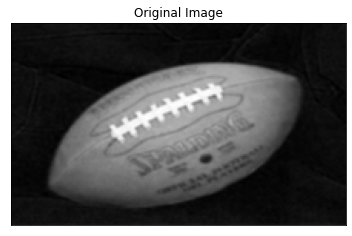

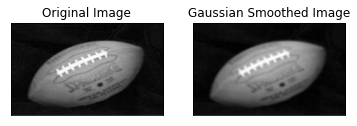

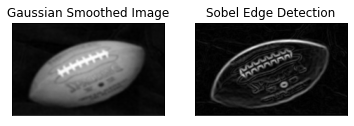

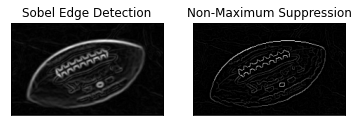

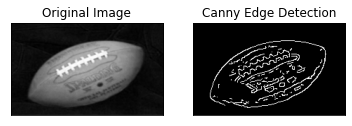

In [64]:
#Load image from files
img = cv2.imread('football.png', 0) #read the image and make it grayscale
plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show() #show the image

# ==================== CANNY ======================
# For this example, I will set the threshold at 0 and 35
final_img, gradient = Canny(img, 0, 35)

# Display the final image
# Original image
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# Final image
plt.subplot(122),plt.imshow(final_img, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

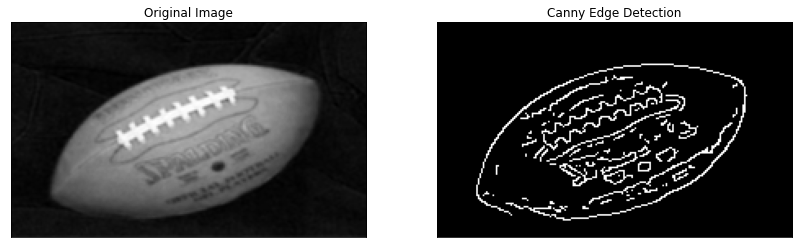

In [65]:
# Just to make the final comparison clearer
fig = plt.figure(figsize=(14,10))
# Original image
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# Final image
plt.subplot(122),plt.imshow(final_img, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()